In [1]:
import graph_tool.all as gt
from math import sqrt

In [2]:
from random import *

In [3]:
csvGraphsPath="../graphs/csv/"
csvGraphFileName="facebook_combined.csv"
csvGraphFilePath=csvGraphsPath+csvGraphFileName
fbGraph=gt.load_graph_from_csv(csvGraphFilePath)

In [4]:
import igraph as ig

In [5]:
F=ig.Graph.Read("../graphs/ncol/facebook_combined.txt",format="ncol").as_undirected()

In [6]:
partition=F.community_multilevel()

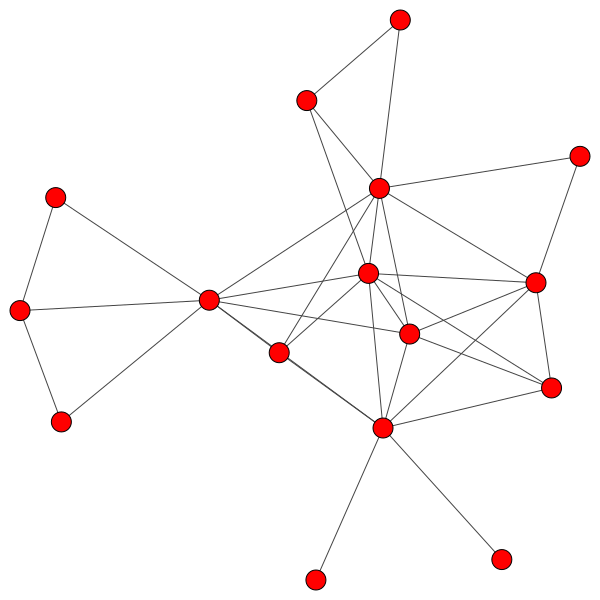

In [7]:
clusters=partition.cluster_graph()
ig.plot(clusters)

In [8]:
len(clusters.vs)
print(clusters.is_weighted())

False


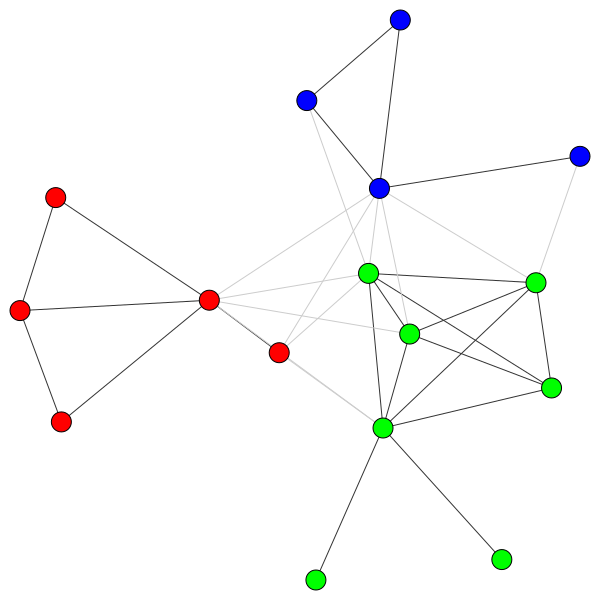

In [9]:
subpartition=clusters.community_leading_eigenvector()
ig.plot(subpartition)

In [10]:
len(subpartition)

3

In [11]:
for c in partition:
    color=[random(),random(),random(),1.]
    for v in c:
        partition.graph.vs[v]["color"]=color
        for e in partition.graph.incident(v):
            ed=partition.graph.es[e]
            if ed.source in c and ed.target in c:
                ed["color"]=[0.,0.,0.,1.]
            else:
                ed["color"]=[0.5,0.5,0.5,1.]

In [12]:
print(partition)

Clustering with 4040 elements and 16 clusters
[ 0] ﻿0, 1, 0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
     20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38,
     39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
     57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
     75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92,
     93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 109,
     110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
     124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138,
     139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
     153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
     167, 168, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179, 180, 181,
     182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
     196, 197, 199, 200, 201, 202, 203,

In [13]:
def assignWorkers(partition,nWorkers):
    assert nWorkers>=0
    assert len(partition.graph.vs)>=nWorkers
    assert len(partition)>=nWorkers

    workerIds=[]
    
    
    
    assert len(workerIds)==nWorkers
    return workerIds

In [14]:
assignWorkers(partition,0)

[]

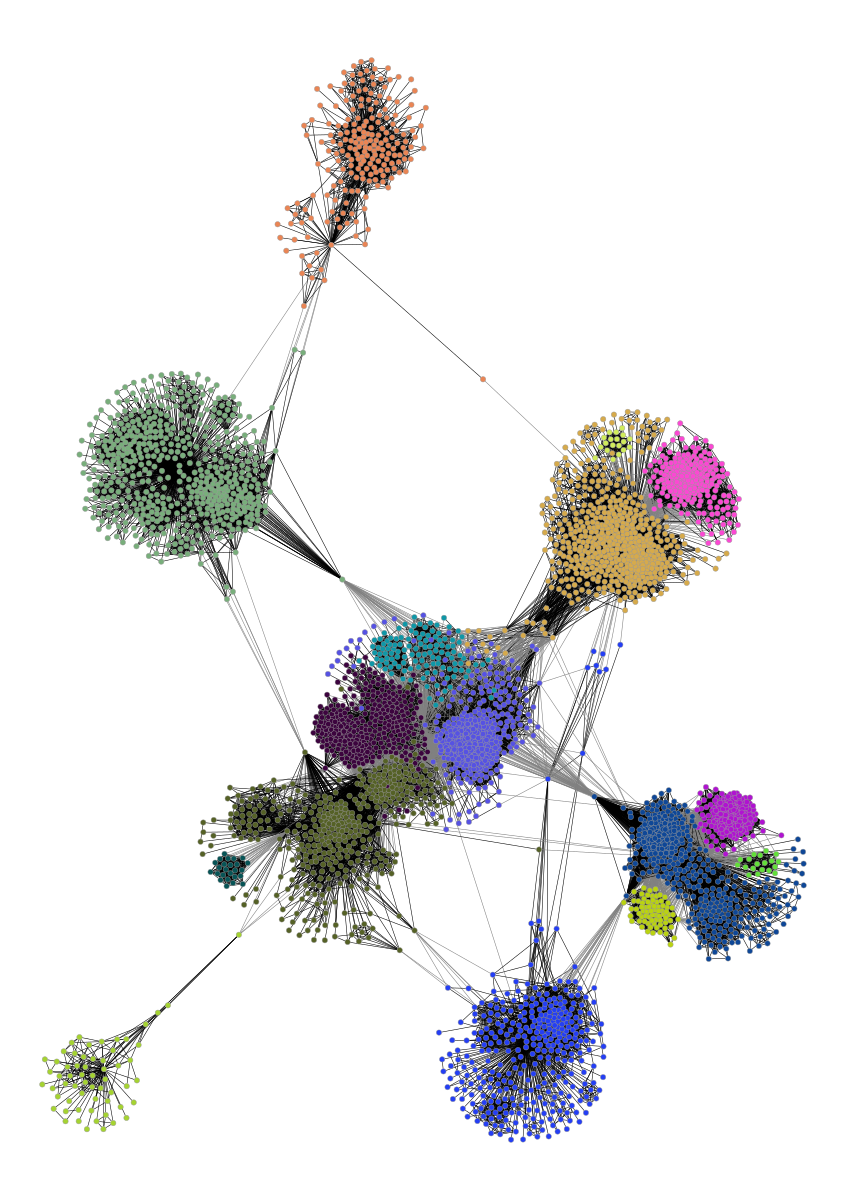

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fed12c23580, at 0x7fed12deee50>

In [15]:
G=partition.graph.to_graph_tool(vertex_attributes={"color":"vector<float>"},edge_attributes={"color":"vector<float>"})
gt.graph_draw(G, vertex_fill_color=G.vertex_properties["color"],edge_color=G.edge_properties["color"])